In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets
from numpy import trapz 

%matplotlib inline

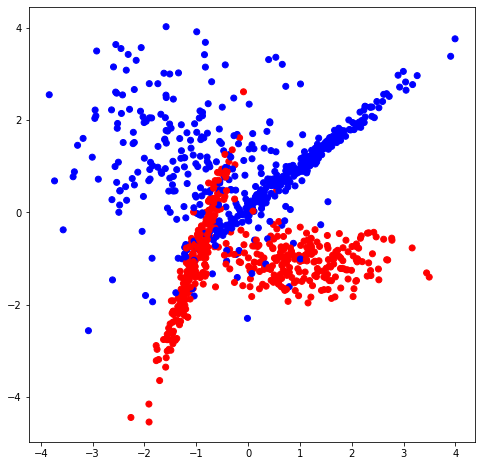

In [38]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=42)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.show()

In [39]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [40]:
def compute_tp_tn_fn_fp(y_act, y_pred):
    tp = sum((y_act == 1) & (y_pred == 1))
    tn = sum((y_act == 0) & (y_pred == 0))
    fn = sum((y_act == 1) & (y_pred == 0))
    fp = sum((y_act == 0) & (y_pred == 1))
    return tp, tn, fp, fn
    
def compute_accuracy(tp, tn, fn, fp):
    return (tp + tn) / (tp + tn + fn + fp)

def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)

def compute_f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

def metrics_report(y_true, y_pred):
    tp, tn, fp, fn = compute_tp_tn_fn_fp(y_true, y_pred)
    
    table = [[tp, fp], [fn, tn]]
    print(table)
    
    accuracy = compute_accuracy(tp, tn, fn, fp)
    precision = compute_precision(tp, fp)
    recall = compute_recall(tp, fn)
    f1_score = compute_f1_score(precision, recall)
    
    print(f'Точность: {precision:.2}\nПолнота: {recall:.2}\nF1: {f1_score:.2}')
    print(f'Accuracy: {accuracy}')

In [41]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (700, 2)
Размер массива признаков тестовой выборки (300, 2)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [42]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

In [43]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

In [44]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses


### Задание 1

In [45]:
def predict(w, X, t = 0.5):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > t): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= t):
            y_predicted[:, i] = 0
    
    return y_predicted

### Задание 2

In [46]:
# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1)) - 1

n_iterations = 100
eta = 1

for eta in [0.1, 1, 10]:
    for n_iterations in [1, 10, 100]:
        w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)
        train_accuracy = 0
        tp = 0
        
        for level_t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: 
            y_predicted_train = predict(w, X_train_tr, level_t)
            
            if train_accuracy < (100 - np.mean(np.abs(y_predicted_train - y_train_tr)*100)):
                tp = level_t
        y_predicted_test = predict(w, X_test_tr, tp)
        y_predicted_train = predict(w, X_train_tr, tp)

# В качестве меры точности возьмем долю правильных ответов
        train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
        test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)
        
        print('eta: ', eta)
        print('n_iterations: ', n_iterations)
        print(f"Итоговый вектор весов w: {w}")
        print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
        print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

eta:  0.1
n_iterations:  1
Итоговый вектор весов w: [[-0.97375893]
 [-0.92138652]]
Точность на обучающей выборке: 42.571
Точность на тестовой выборке: 38.667
eta:  0.1
n_iterations:  10
Итоговый вектор весов w: [[-0.73689776]
 [-0.28392515]]
Точность на обучающей выборке: 50.429
Точность на тестовой выборке: 48.667
eta:  0.1
n_iterations:  100
Итоговый вектор весов w: [[-0.20587335]
 [ 1.48101723]]
Точность на обучающей выборке: 63.714
Точность на тестовой выборке: 63.000
eta:  1
n_iterations:  1
Итоговый вектор весов w: [[-0.73758932]
 [-0.21386524]]
Точность на обучающей выборке: 50.571
Точность на тестовой выборке: 49.333
eta:  1
n_iterations:  10
Итоговый вектор весов w: [[-0.19747265]
 [ 1.55733758]]
Точность на обучающей выборке: 64.714
Точность на тестовой выборке: 65.000
eta:  1
n_iterations:  100
Итоговый вектор весов w: [[-0.29696665]
 [ 2.24730793]]
Точность на обучающей выборке: 73.857
Точность на тестовой выборке: 74.667
eta:  10
n_iterations:  1
Итоговый вектор весов w: [

### Задание 3

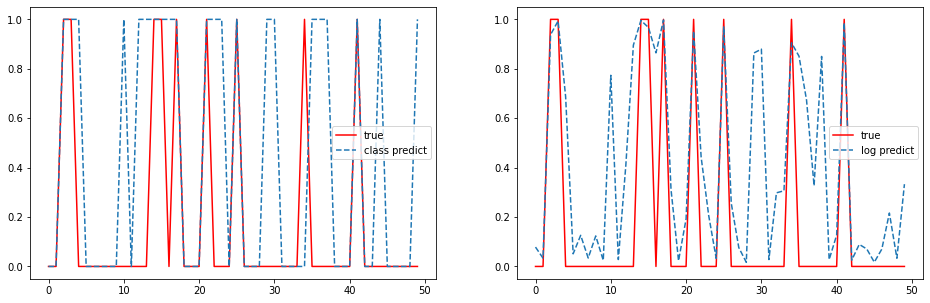

In [47]:

y_pred_log = sigmoid(np.dot(w.T,  X_train_tr))
N = 50
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.plot(y_predicted_train[0,:N],'r', label = 'true')
plt.plot(y_train_tr[0,:N],'--', label = 'class predict')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_predicted_train[0,:N],'r', label = 'true')
plt.plot(y_pred_log[0,:N],'--',label = 'log predict')
plt.legend()

plt.show()

In [48]:
metrics_report(y_train_tr[0], y_predicted_train[0])

[[168, 5], [178, 349]]
Точность: 0.97
Полнота: 0.49
F1: 0.65
Accuracy: 0.7385714285714285


### Задание 4

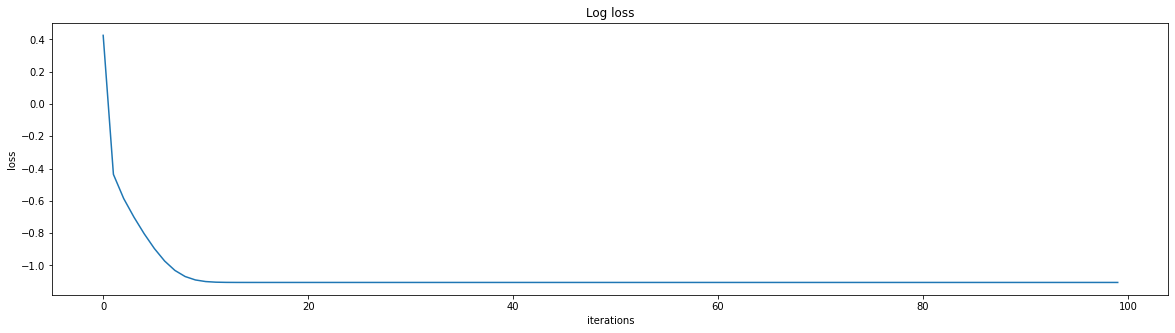

In [49]:
plt.figure(figsize = (20,5))
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), np.log(losses))

In [50]:
def get_fpr(fp, tn):
    return fp / (fp + tn)

def get_trp(tp, fn):
    return tp / (tp + fn)

def get_fpr_tpr(y_true, y_pred):
    tp, tn, fp, fn = compute_tp_tn_fn_fp(y_true, y_pred)
    return get_fpr(fp, tn), get_trp(tp, fn)

def show_ROC(w, X, Y_true):
    TPR = []
    FPR = []
    
    for i in np.linspace(0, 1, 100).tolist():
        y_predicted_test = predict(w, X, i)
        fpr, tpr = get_fpr_tpr(Y_true[0], y_predicted_test[0])
        TPR.append(tpr)
        FPR.append(fpr)
        
    AUC_ROC = trapz(TPR, x = FPR, dx=0.1)
    
    plt.title('ROC curve')
    plt.ylim(0, 1.05)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
    plt.plot(FPR, TPR)
    plt.show()
    
    

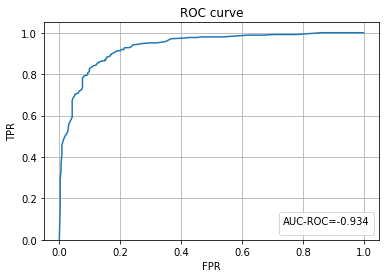

In [51]:
show_ROC(w, X_train_tr, y_train_tr)

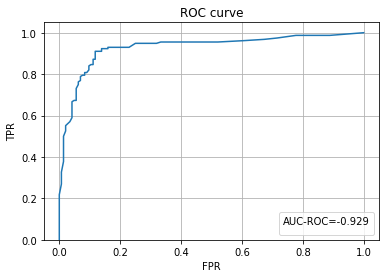

In [52]:
### тестовая выборка
show_ROC(w, X_test_tr, y_test_tr)